<a href="https://colab.research.google.com/github/HeshanNavindu-7/oilspill-detection/blob/main/oilspill_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets


In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import opendatasets as od

In [3]:
od.download("https://www.kaggle.com/datasets/saanvitayal07/oil-spill-and-no-oil-spill")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: heshannavindu
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/saanvitayal07/oil-spill-and-no-oil-spill


100%|██████████| 26.5M/26.5M [00:02<00:00, 12.7MB/s]


In [4]:
import os
import random
import matplotlib.pyplot as plt
import cv2

#define path
dataset_dir="/content/oil-spill-and-no-oil-spill/oilspill_dataset_fix"
class_count={}
for detection_class in os.listdir(dataset_dir):
  print(detection_class)
  class_dir= os.path.join(dataset_dir,detection_class)
  if os.path.isdir(class_dir):
    num_images=len(os.listdir(class_dir))
    class_count[detection_class]=num_images




train
test


Train Data
Displaying 4 samples from 'nospill' class:
Displaying 4 samples from 'oilspill' class:


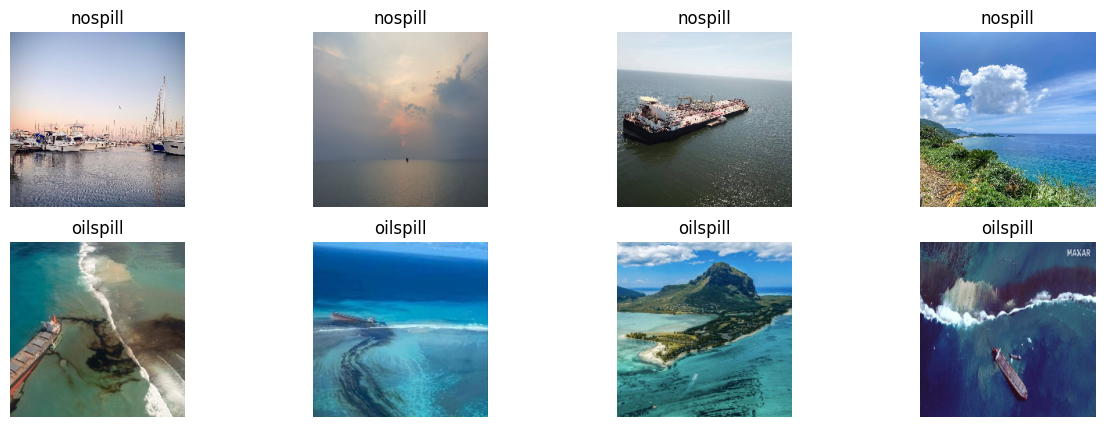

Test Data
Displaying 4 samples from 'nospill' class:
Displaying 4 samples from 'oilspill' class:


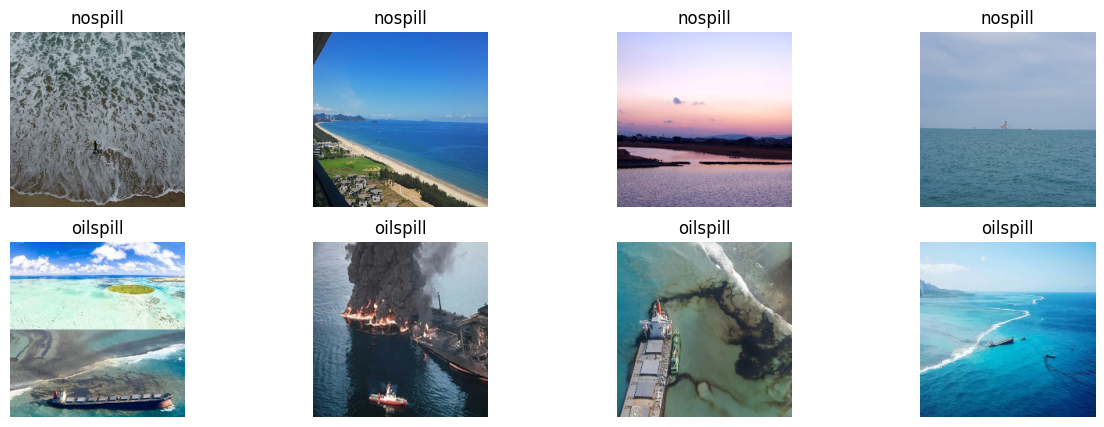

In [5]:
import cv2
import matplotlib.pyplot as plt
import os

# Define subdirectories for train and test data
train_dir = '/content/oil-spill-and-no-oil-spill/oilspill_dataset_fix/train'
test_dir = '/content/oil-spill-and-no-oil-spill/oilspill_dataset_fix/test'

# Define image size and batch size
target_size = (224,224)
batch_size = 8

# Define classes
classes = ['nospill', 'oilspill']

# Display sample data
def display_sample(directory, num_samples=4):
    fig, axs = plt.subplots(len(classes), num_samples, figsize=(15, 5))
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(directory, class_name)
        print(f"Displaying {num_samples} samples from '{class_name}' class:")

        for j, filename in enumerate(os.listdir(class_dir)):
            if j >= num_samples:
                break
            img_path = os.path.join(class_dir, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, target_size)  # Resize image
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            axs[i, j].set_title(class_name)
    plt.show()

print("Train Data")
display_sample(train_dir)
print("Test Data")
display_sample(test_dir)


In [6]:
# Define directories (adjust these paths to your setup)
train_dir = '/content/oil-spill-and-no-oil-spill/oilspill_dataset_fix/train'
test_dir = '/content/oil-spill-and-no-oil-spill/oilspill_dataset_fix/test'

Found 197 images belonging to 2 classes.


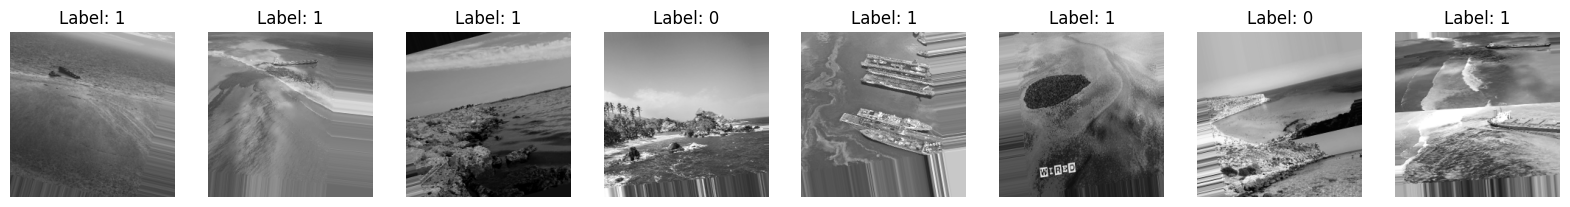

In [7]:
import cv2
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Define custom augmentation function
def custom_augmentation(image):
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.rgb_to_grayscale(image)
    return image

# Create an ImageDataGenerator with various augmentations including synthetic data generation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=custom_augmentation
)
# Create train generator
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

# Get a batch of augmented images
images, labels = next(train_generator)

# Display augmented images
def display_augmented_images(images, labels, num_images=8):
    fig, axs = plt.subplots(1, num_images, figsize=(20, 20))
    for i in range(num_images):
        axs[i].imshow(images[i])
        axs[i].axis('off')
        axs[i].set_title(f'Label: {int(labels[i])}')
    plt.show()

# Display a batch of augmented images
display_augmented_images(images, labels)


In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load the Xception model without the top layer
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

# Define the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Print the model summary
model.summary()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


83683744/83683744 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  

In [9]:
!pip install visualkeras


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 5.5 MB/s eta 0:00:00


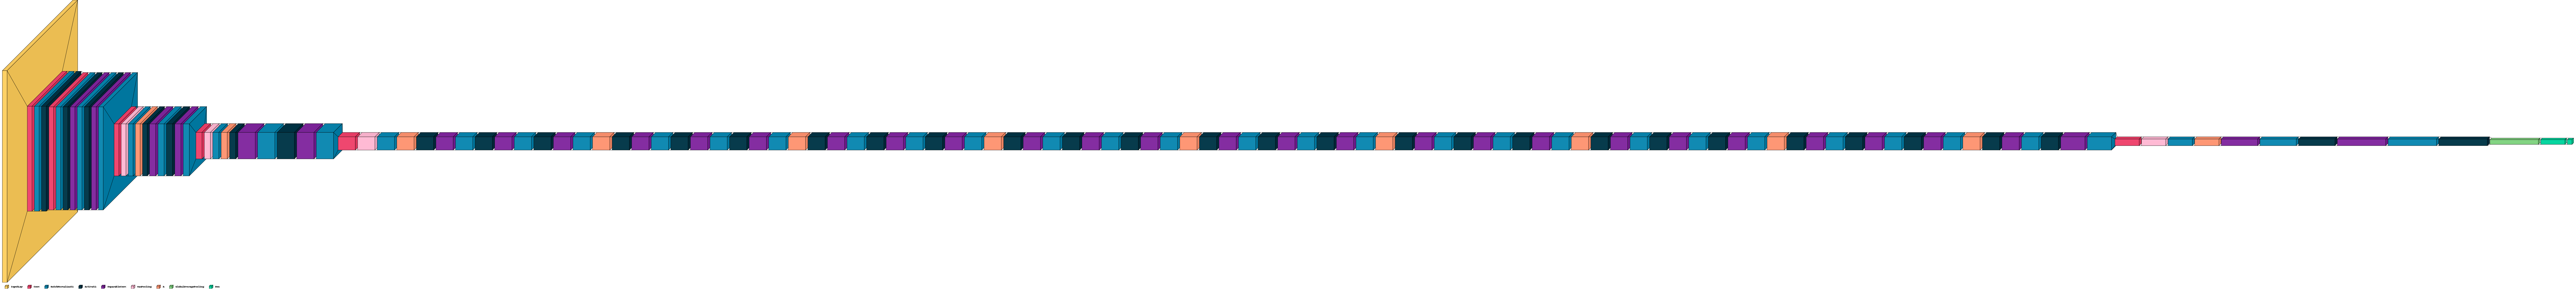

In [10]:
import visualkeras
visualkeras.layered_view(model, legend=True)

In [15]:
# Import necessary libraries
from keras.preprocessing.image import ImageDataGenerator

# Create data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    validation_split=0.2  # Set validation split
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary',
    subset='training'  # Use training subset
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary',
    subset='validation'  # Use validation subset
)

# Test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary'
)


Found 159 images belonging to 2 classes.
Found 38 images belonging to 2 classes.
Found 49 images belonging to 2 classes.


In [16]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, reduce_lr]
)

# Unfreeze some layers and fine-tune
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Re-compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/15
19/19 [==============================] - 50s 2s/step - loss: 0.8740 - accuracy: 0.6490 - val_loss: 0.5284 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 2/15
19/19 [==============================] - 44s 2s/step - loss: 0.5173 - accuracy: 0.7351 - val_loss: 0.5509 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 3/15
19/19 [==============================] - 45s 2s/step - loss: 0.4750 - accuracy: 0.8013 - val_loss: 0.3925 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 4/15
19/19 [==============================] - 44s 2s/step - loss: 0.2978 - accuracy: 0.8808 - val_loss: 0.4852 - val_accuracy: 0.8438 - lr: 0.0010
Epoch 5/15
19/19 [==============================] - 47s 2s/step - loss: 0.2634 - accuracy: 0.9139 - val_loss: 0.5645 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 6/15
19/19 [==============================] - 45s 2s/step - loss: 0.2283 - accuracy: 0.8742 - val_loss: 0.4146 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 7/15
19/19 [==============================] - 44s 2s/step - loss: 0.1951 - a

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


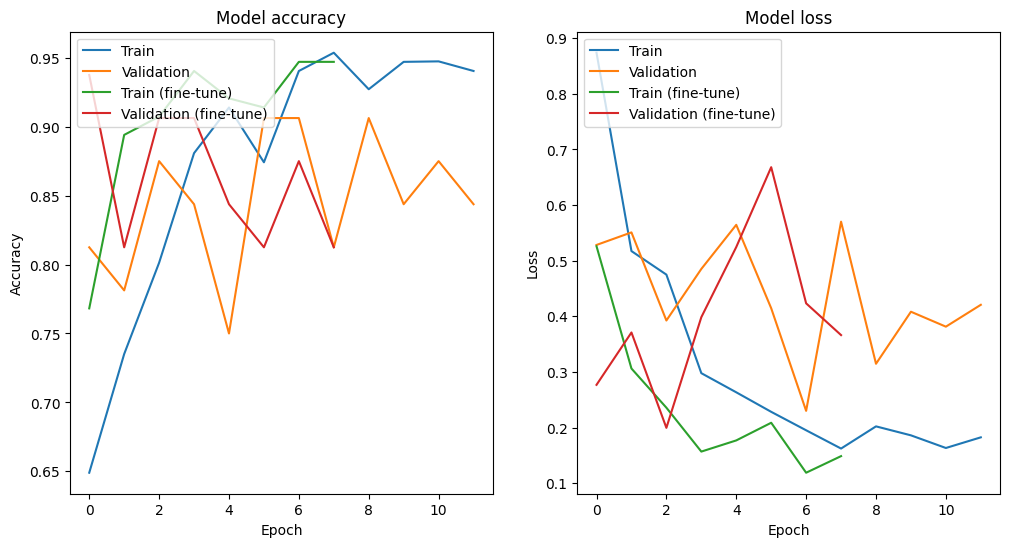

In [17]:
# Save the model
model.save('oil_spill_detection_xception.h5')

# Plotting training history
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Train (fine-tune)', 'Validation (fine-tune)'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Train (fine-tune)', 'Validation (fine-tune)'], loc='upper left')

plt.show()

In [20]:

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

7/7 [==============================] - 11s 2s/step - loss: 0.4666 - accuracy: 0.8367
Test Loss: 0.46659302711486816
Test Accuracy: 0.8367347121238708


In [23]:
train_loss, train_accuracy = model.evaluate(train_generator)
print(f'Train Loss: {train_loss}')
print(f'Train Accuracy: {train_accuracy}')

20/20 [==============================] - 38s 2s/step - loss: 0.1294 - accuracy: 0.9434
Train Loss: 0.1294385939836502
Train Accuracy: 0.9433962106704712


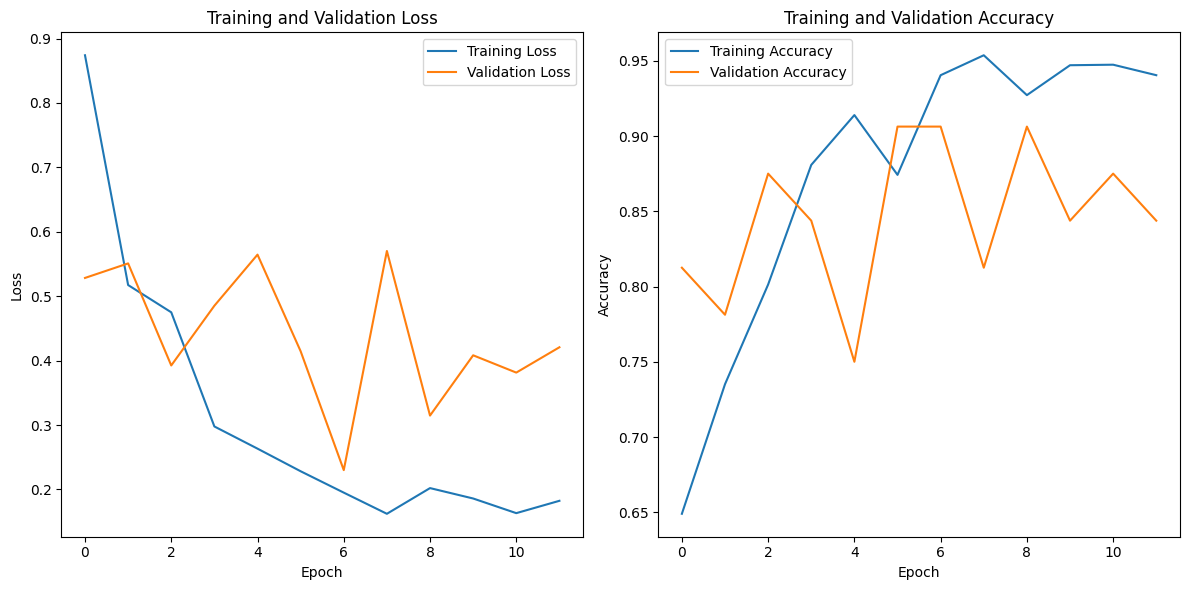

In [21]:
import matplotlib.pyplot as plt

# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot training and validation loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

# Plot training and validation accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

# Adjust layout
plt.tight_layout()
plt.show()


1/1 [==============================] - 1s 1s/step
The image is predicted to be an oil spill image with 98.22% confidence.


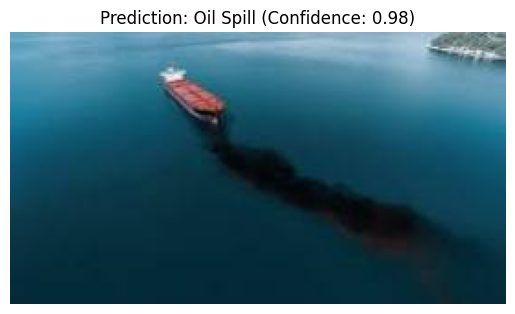

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('oil_spill_detection_xception.h5')

# Function to preprocess and load an image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize to [0, 1]
    return img_array

# Function to make prediction
def predict_image(model, img_path):
    img = load_and_preprocess_image(img_path)
    prediction = model.predict(img)
    return prediction[0][0], prediction

# Path to the image to be checked
img_path = '/content/download (5).jfif'

# Make a prediction
prediction_prob, prediction = predict_image(model, img_path)

# Print the result and accuracy
if prediction_prob >= 0.5:
    print("The image is predicted to be an oil spill image with {:.2f}% confidence.".format(prediction_prob * 100))
else:
    print("The image is predicted to be a no spill image with {:.2f}% confidence.".format((1 - prediction_prob) * 100))

# Optional: Display the image
img = image.load_img(img_path)
plt.imshow(img)
plt.title(f'Prediction: {"Oil Spill" if prediction_prob >= 0.5 else "No Spill"} (Confidence: {prediction_prob:.2f})')
plt.axis('off')
plt.show()


1/1 [==============================] - 1s 998ms/step
The image is predicted to be a no spill image with 61.80% confidence.


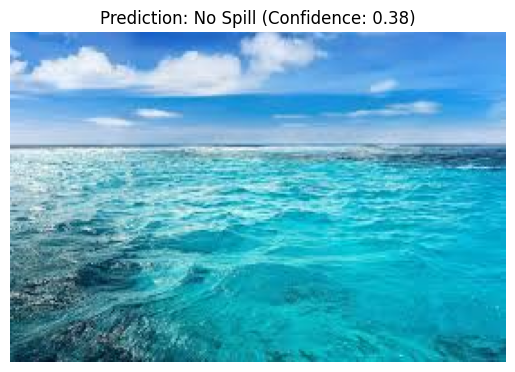

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('oil_spill_detection_xception.h5')

# Function to preprocess and load an image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize to [0, 1]
    return img_array

# Function to make prediction
def predict_image(model, img_path):
    img = load_and_preprocess_image(img_path)
    prediction = model.predict(img)
    return prediction[0][0], prediction

# Path to the image to be checked
img_path = '/content/download (6).jfif'

# Make a prediction
prediction_prob, prediction = predict_image(model, img_path)

# Print the result and accuracy
if prediction_prob >= 0.5:
    print("The image is predicted to be an oil spill image with {:.2f}% confidence.".format(prediction_prob * 100))
else:
    print("The image is predicted to be a no spill image with {:.2f}% confidence.".format((1 - prediction_prob) * 100))

# Optional: Display the image
img = image.load_img(img_path)
plt.imshow(img)
plt.title(f'Prediction: {"Oil Spill" if prediction_prob >= 0.5 else "No Spill"} (Confidence: {prediction_prob:.2f})')
plt.axis('off')
plt.show()


In [26]:
# Assuming you have trained your model and have access to the history object
# The history object contains training and validation metrics for each epoch

# Get the validation accuracy
validation_accuracy = history.history['val_accuracy']

# Print the last validation accuracy recorded during training
print("Validation Accuracy:", validation_accuracy[-1])
# Assuming you have trained your model and have access to the history object
# The history object contains training and validation metrics for each epoch

# Get the validation loss
validation_loss = history.history['val_loss']

# Print the last validation loss recorded during training
print("Validation Loss:", validation_loss[-1])


Validation Accuracy: 0.84375
Validation Loss: 0.42075231671333313
